In [124]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, cross_val_score, KFold, GridSearchCV
from sklearn.preprocessing import LabelEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report
import pickle

In [125]:
# Save the model
def save_model(model, filename):
    with open(filename, 'wb') as file:
        pickle.dump(model, file)

# Load the model
def load_model(filename):
    with open(filename, 'rb') as file:
        return pickle.load(file)


In [126]:
df = pd.read_csv("train.csv")
print(df['Target_Status'].value_counts(normalize=False))

Target_Status
Approved                           31031
Phase 2                            29621
Phase 1                            16912
Phase 3                            15514
Investigative                       9174
Phase 1/2                           6160
Discontinued in Phase 2             5815
Terminated                          5234
Patented                            3055
Discontinued in Phase 3             2510
Discontinued in Phase 1             2379
Preclinical                         1978
Withdrawn from market               1519
Phase 2/3                           1432
Phase 4                              507
Clinical trial                       348
Preregistration                      228
Phase 1b                             157
Phase 2a                             135
Discontinued in Preregistration      131
Discontinued in Phase 1/2            129
Registered                           121
Approved (orphan drug)               105
Application submitted                 80
IN

In [127]:
# Remove unwanted columns
columns_to_remove = ['ID', 'TargetID', 'DRUGID', 'PUBCHCID', 'UNIPROID', 'SYNONYMS', 
                     'FUNCTION', 'SEQUENCE', 'Accession Number']
df.drop(columns=columns_to_remove, inplace=True)

In [128]:
# Select the features and target (excluding DRUGTYPE and Drug_Status)
features = ['DRUGNAME', 'Disease_of_highest_status', 'TARGNAME', 'GENENAME', 'BIOCLASS', 'Disease']
X = df[features].copy()  
y = df['Target_Status'].copy()

In [129]:
# Encode categorical variables and save the encoders
le_dict = {}
for feature in X.columns:
    if X[feature].dtype == 'object':
        le = LabelEncoder()
        X[feature] = le.fit_transform(X[feature])
        np.save(f'{feature}_encoder_classes.npy', le.classes_)
        le_dict[feature] = le

# Encode target variable
le_target = LabelEncoder()
y = le_target.fit_transform(y)
np.save('target_status_classes.npy', le_target.classes_)
le_dict['Target_Status'] = le_target

print("Encoding complete. Encoders saved as .npy files.")

Encoding complete. Encoders saved as .npy files.


In [130]:
# Split the data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


In [131]:
# Train the Decision Tree model
dt = DecisionTreeClassifier(random_state=42)
dt.fit(X_train, y_train)

DecisionTreeClassifier(random_state=42)

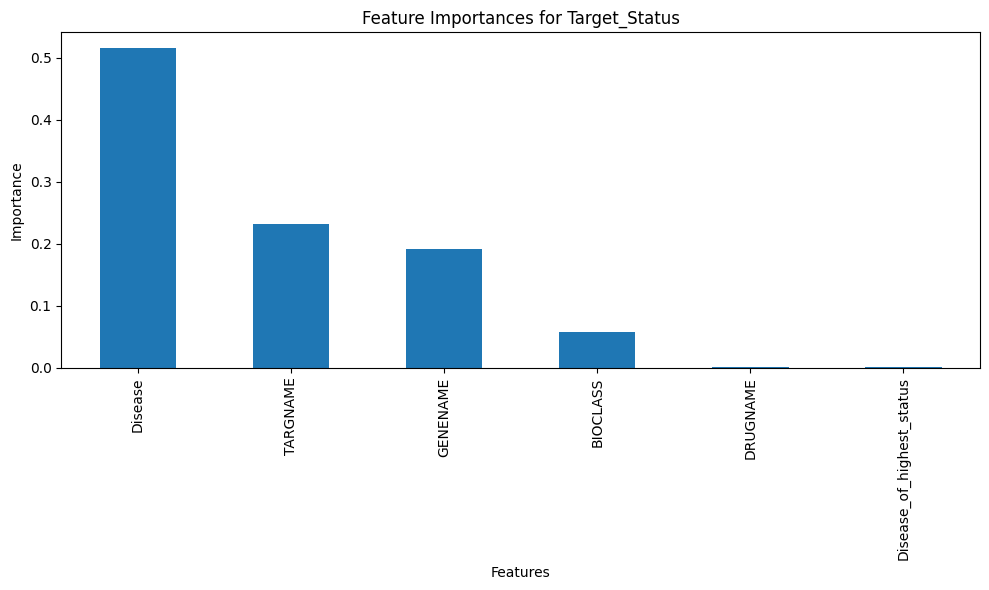

In [132]:
# Get and plot feature importances
importances = pd.Series(dt.feature_importances_, index=X.columns).sort_values(ascending=False)
plt.figure(figsize=(10, 6))
importances.plot(kind='bar')
plt.title('Feature Importances for Target_Status')
plt.xlabel('Features')
plt.ylabel('Importance')
plt.tight_layout()
plt.show()

In [133]:
# Print feature importances
print("\nFeature Importances:")
for feature, importance in importances.items():
    print(f"{feature}: {importance:.4f}")


Feature Importances:
Disease: 0.5155
TARGNAME: 0.2326
GENENAME: 0.1917
BIOCLASS: 0.0577
DRUGNAME: 0.0015
Disease_of_highest_status: 0.0010


In [134]:
# Evaluate the Decision Tree model
y_pred = dt.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred, average='weighted')
recall = recall_score(y_test, y_pred, average='weighted')
f1 = f1_score(y_test, y_pred, average='weighted')

print("\nDecision Tree Classifier Results:")
print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1 Score: {f1:.4f}")


Decision Tree Classifier Results:
Accuracy: 0.9917
Precision: 0.9917
Recall: 0.9917
F1 Score: 0.9917


In [135]:
# Train the Random Forest model
rfc = RandomForestClassifier(n_estimators=100, random_state=42)
rfc.fit(X_train, y_train)

RandomForestClassifier(random_state=42)

In [136]:
# Evaluate the Random Forest model
y_pred = rfc.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred, average='weighted')
recall = recall_score(y_test, y_pred, average='weighted')
f1 = f1_score(y_test, y_pred, average='weighted')

print("\nRandom Forest Classifier Results:")
print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1 Score: {f1:.4f}")


Random Forest Classifier Results:
Accuracy: 0.9509
Precision: 0.9510
Recall: 0.9509
F1 Score: 0.9508


In [137]:
# Define the models
models = {
    'Random Forest': RandomForestClassifier(n_estimators=100, random_state=42)
}

# Define the parameter grid to search over for Decision Tree
dt_param_grid = {
    'criterion':  ['entropy'],          
    'max_depth': [None, 1],                
    'min_samples_split': [2, 10],       
    'min_samples_leaf': [1, 5, 10],     
    'max_features': [None]              
}

# Create a Decision Tree classifier and perform grid search
dt_model = DecisionTreeClassifier(random_state=42)
dt_grid_search = GridSearchCV(estimator=dt_model, param_grid=dt_param_grid, cv=5, scoring='accuracy')

# Add the grid search wrapped Decision Tree to the models dictionary
models['Decision Tree'] = dt_grid_search

# Define the K-Fold cross-validator
cv = KFold(n_splits=5, shuffle=True, random_state=42)

# Store results for both models
results = {}

for name, model in models.items():
    if name == 'Decision Tree':
        # Perform grid search for Decision Tree
        model.fit(X, y)
        best_model = model.best_estimator_
        accuracy_scores = cross_val_score(best_model, X, y, cv=cv, scoring='accuracy')
        f1_scores = cross_val_score(best_model, X, y, cv=cv, scoring='f1_weighted')
    else:
        # Perform regular cross-validation for Random Forest
        accuracy_scores = cross_val_score(model, X, y, cv=cv, scoring='accuracy')
        f1_scores = cross_val_score(model, X, y, cv=cv, scoring='f1_weighted')
    
    results[name] = {
        'Accuracy': accuracy_scores.mean(),
        'F1 Score': f1_scores.mean()
    }

C:\Users\Akshat\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\sklearn\model_selection\_split.py:776: UserWarning: The least populated class in y has only 4 members, which is less than n_splits=5.
  warnings.warn(


In [138]:
# Display cross-validation results
print("\nCross-Validation Results:")
for name, result in results.items():
    print(f"{name}: Accuracy = {result['Accuracy']:.4f}, F1 Score = {result['F1 Score']:.4f}")



Cross-Validation Results:
Random Forest: Accuracy = 0.9507, F1 Score = 0.9506
Decision Tree: Accuracy = 0.9933, F1 Score = 0.9933


In [139]:
# Determine the best model
best_model_name = max(results, key=lambda name: results[name]['F1 Score'])
print(f"\nBest Model: {best_model_name}")

best_model = models[best_model_name]
best_model.fit(X, y)


Best Model: Decision Tree


C:\Users\Akshat\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\sklearn\model_selection\_split.py:776: UserWarning: The least populated class in y has only 4 members, which is less than n_splits=5.
  warnings.warn(


GridSearchCV(cv=5, estimator=DecisionTreeClassifier(random_state=42),
             param_grid={'criterion': ['entropy'], 'max_depth': [None, 1],
                         'max_features': [None], 'min_samples_leaf': [1, 5, 10],
                         'min_samples_split': [2, 10]},
             scoring='accuracy')

In [140]:
def encode_feature(feature_series, encoder_classes, unknown_value=-1):
    # Create a new LabelEncoder
    le = LabelEncoder()
    
    # Fit the encoder with known classes and an additional 'Unknown' class
    le.classes_ = np.concatenate([encoder_classes, ['Unknown']])
    
    # Transform the feature, replacing unseen labels with 'Unknown'
    encoded = feature_series.map(lambda x: x if x in encoder_classes else 'Unknown')
    return le.transform(encoded)

# Load the test dataset
test_df = pd.read_csv("test.csv")

# Select the same features as in training
X_test = test_df[features].copy()

# Encode the test dataset
for feature in features:
    if X_test[feature].dtype == 'object':
        encoder_classes = np.load(f'{feature}_encoder_classes.npy', allow_pickle=True)
        X_test[feature] = encode_feature(X_test[feature], encoder_classes)

print("Test set encoding complete.")

Test set encoding complete.


In [141]:
# Make predictions on the test set
y_pred_encoded = best_model.predict(X_test)

# Decode the predictions back to original labels
y_pred = le_target.inverse_transform(y_pred_encoded)

# Create submission DataFrame
submission = pd.DataFrame({
    'ID': test_df['ID'],
    'Prediction': y_pred
})

# Save the submission file
submission.to_csv('submission.csv', index=False)
print("Submission file created: submission.csv")

Submission file created: submission.csv


In [142]:
# Display the first few rows of the submission file
print("\nFirst few rows of the submission file:")
print(submission.head())

# Check for missing values
print("\nMissing values in submission file:")
print(submission.isnull().sum())


First few rows of the submission file:
       ID Prediction
0    1076   Approved
1  190816    Phase 3
2  180551    Phase 3
3   51630   Approved
4   50566  Phase 1/2

Missing values in submission file:
ID            0
Prediction    0
dtype: int64
